In [1]:
import sys
import tensorflow as tf

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)


2025-07-25 17:50:07.733197: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 17:50:07.878954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-25 17:50:08.001708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-25 17:50:08.002434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-25 17:50:08.150958: I tensorflow/core/platform/cpu_feature_gua

Python version: 3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]
TensorFlow version: 2.16.2


In [3]:
from tensorflow.python.client import device_lib
print("\nAvailable devices:")
print(device_lib.list_local_devices())

# Or a cleaner GPU-specific check
gpus = tf.config.list_physical_devices('GPU')
print(f"\nNum GPUs Available: {len(gpus)}")
if gpus:
    for gpu in gpus:
        print("GPU Name:", gpu.name)



Available devices:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9895365891074480780
xla_global_id: -1
]

Num GPUs Available: 0


2025-07-25 17:51:03.452758: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-25 17:51:03.634743: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-07-25 17:51:03.713217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/li

In [4]:
import platform
import multiprocessing

print("\nCPU Info:")
print("Processor:", platform.processor())
print("Machine:", platform.machine())
print("CPU cores:", multiprocessing.cpu_count())



CPU Info:
Processor: x86_64
Machine: x86_64
CPU cores: 16


In [2]:
print("\nTensorFlow build configuration:")
print(tf.sysconfig.get_build_info())



TensorFlow build configuration:
OrderedDict({'cpu_compiler': '/usr/lib/llvm-17/bin/clang', 'cuda_compute_capabilities': ['sm_50', 'sm_60', 'sm_70', 'sm_80', 'compute_90'], 'cuda_version': '12.3', 'cudnn_version': '8', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': True})


In [1]:
import pickle, os, glob, ast
import os
from utils import *
from models import * 
import yaml
from codecarbon import EmissionsTracker
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import RootMeanSquaredError

from tensorflow.keras.callbacks import ModelCheckpoint

from utils import create_dl_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np



2025-07-20 23:58:51.012237: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 23:58:51.043821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-20 23:58:51.095457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-20 23:58:51.095560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-20 23:58:51.130269: I tensorflow/core/platform/cpu_feature_gua

In [2]:
seed = 42
set_seed(seed)

with open('../configs/config_banikoara.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)


print('Config file: {}'.format(config))

"""Extract data params"""
data_params = config['data_params']

B_ARG = data_params['B_ARG']

"""Create a directory to save results"""
save_path = '../tests/' #data_params['save_path']

"""Create subdirectories to save results"""
dirs = [data_params['city']+"/Images5/",
        data_params['city']+"/Models5/",
        data_params['city']+"/Excel5/"]

for path in dirs:
    if not os.path.exists(save_path+path):
        os.makedirs(save_path+path)

"""Lagged data path"""

Config file: {'data_params': {'data_path': '../datasets/', 'lagged_data_path': '../datasets/lagged/', 'save_path': '../results/', 'dataset': 'Banikoara_with_SPI6.csv', 'city': 'Banikoara', 'target_column': 'SPI6(t)', 'scaling_type': 'minmax', 'include_target_lags': True, 'split_date': '2014-01-31', 'window_size': 5, 'n_output_steps': 1, 'B_ARG': 30}, 'conv1d_model': {'kernel_size': 3, 'dense_layers': 3, 'activ': ['relu', 'relu', 'linear'], 'dense_units': [64, 32, 1], 'cnn_units': 64, 'epochs': 20, 'batch_size': 64, 'lr': 0.001}, 'lstm_model': {'lstm_layers': 2, 'dense_layers': 2, 'activ': ['relu', 'linear'], 'dense_units': [32, 1], 'lstm_units': [64, 32], 'dropout': False, 'dropout_val': 0, 'epochs': 300, 'batch_size': 64}, 'gru_model': {'gru_layers': 2, 'dense_layers': 2, 'activ': ['relu', 'linear'], 'dense_units': [32, 1], 'gru_units': [64, 32], 'dropout': False, 'dropout_val': 0, 'epochs': 300, 'batch_size': 64}, 'conv1d_lstm_model': {'filters': 64, 'kernel_size': 5, 'lstm_layers': 

'Lagged data path'

In [3]:
# ---------------------------------- Deep Learning ------------------------------------------
# --- Step 1: Load raw data ---
dataset_path = data_params['data_path'] + 'raw/' + data_params['dataset']
dataset = pd.read_csv(dataset_path)
dataset['DATE'] = pd.to_datetime(dataset['DATE'], dayfirst=True)
dataset = dataset.set_index('DATE')

dataset.head()


,PS,T2M,RH2M,WD2M,WS2M,GWETPROF,CLOUD_AMT,TOA_SW_DWN,PRECTOTCORR_SUM,ALLSKY_SFC_SW_DWN,SPI6,Moving_Sum_6
DATE,,,,,,,,,,,,
1981-01-31,98.05,22.05,34.62,58.69,2.73,0.55,NaN,NaN,0.00,NaN,NaN,NaN
1981-02-28,97.85,26.33,24.62,73.88,2.71,0.52,NaN,NaN,0.00,NaN,NaN,NaN
1981-03-31,97.75,30.48,34.56,105.81,2.16,0.51,NaN,NaN,5.27,NaN,NaN,NaN
1981-04-30,97.66,30.79,50.38,215.50,2.62,0.50,NaN,NaN,42.19,NaN,NaN,NaN
1981-05-31,97.85,28.11,71.88,233.12,2.42,0.52,NaN,NaN,94.92,NaN,NaN,NaN


In [4]:
dataset.head(10)

,PS,T2M,RH2M,WD2M,WS2M,GWETPROF,CLOUD_AMT,TOA_SW_DWN,PRECTOTCORR_SUM,ALLSKY_SFC_SW_DWN,SPI6,Moving_Sum_6
DATE,,,,,,,,,,,,
1981-01-31,98.05,22.05,34.62,58.69,2.73,0.55,NaN,NaN,0.00,NaN,NaN,NaN
1981-02-28,97.85,26.33,24.62,73.88,2.71,0.52,NaN,NaN,0.00,NaN,NaN,NaN
1981-03-31,97.75,30.48,34.56,105.81,2.16,0.51,NaN,NaN,5.27,NaN,NaN,NaN
1981-04-30,97.66,30.79,50.38,215.50,2.62,0.50,NaN,NaN,42.19,NaN,NaN,NaN
1981-05-31,97.85,28.11,71.88,233.12,2.42,0.52,NaN,NaN,94.92,NaN,NaN,NaN
1981-06-30,97.99,28.12,71.06,220.44,2.39,0.54,NaN,NaN,226.76,NaN,-0.111216,369.14
1981-07-31,98.03,25.51,82.50,230.19,2.16,0.62,NaN,NaN,237.30,NaN,0.747892,606.44
1981-08-31,98.02,25.32,84.00,231.25,1.62,0.66,NaN,NaN,242.58,NaN,1.626116,849.02
1981-09-30,98.04,25.25,84.19,222.94,1.49,0.75,NaN,NaN,184.57,NaN,2.275244,1028.32


In [5]:
# --- Step 2: Select columns ---
target_column = 'SPI6'
selected_columns = ['PS', 'T2M', 'RH2M', 'WS2M', 'GWETPROF', 'PRECTOTCORR_SUM', 'SPI6']

# --- Step 3: Normalize features and target separately ---
split_date = pd.to_datetime(data_params['split_date'])
dataset_train = dataset.loc[:split_date]
dataset_test = dataset.loc[split_date:]

features_only = [col for col in selected_columns if col != target_column]

scaler_X = MinMaxScaler(feature_range=(-1, 1)).fit(dataset_train[features_only])

scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(dataset_train[[target_column]])

dataset_train_scaled = dataset_train.copy()
dataset_test_scaled = dataset_test.copy()

dataset_train_scaled[features_only] = scaler_X.transform(dataset_train[features_only])
dataset_test_scaled[features_only] = scaler_X.transform(dataset_test[features_only])

dataset_train_scaled[[target_column]] = scaler_y.transform(dataset_train[[target_column]])
dataset_test_scaled[[target_column]] = scaler_y.transform(dataset_test[[target_column]])

dataset_scaled = pd.concat([dataset_train_scaled, dataset_test_scaled])



In [6]:
dataset_scaled.head(10)

,PS,T2M,RH2M,WD2M,WS2M,GWETPROF,CLOUD_AMT,TOA_SW_DWN,PRECTOTCORR_SUM,ALLSKY_SFC_SW_DWN,SPI6,Moving_Sum_6
DATE,,,,,,,,,,,,
1981-01-31,0.512821,-0.913590,-0.399542,58.69,0.148438,-0.481481,NaN,NaN,-1.000000,NaN,NaN,NaN
1981-02-28,0.000000,-0.241163,-0.668685,73.88,0.132813,-0.703704,NaN,NaN,-1.000000,NaN,NaN,NaN
1981-03-31,-0.256410,0.410841,-0.401157,105.81,-0.296875,-0.777778,NaN,NaN,-0.967763,NaN,NaN,NaN
1981-04-30,-0.487179,0.459544,0.024627,215.50,0.062500,-0.851852,NaN,NaN,-0.741918,NaN,NaN,NaN
1981-05-31,0.000000,0.038492,0.603284,233.12,-0.093750,-0.703704,NaN,NaN,-0.419361,NaN,NaN,NaN
1981-06-30,0.358974,0.040063,0.581214,220.44,-0.117187,-0.555556,NaN,NaN,0.387123,NaN,-0.282052,369.14
1981-07-31,0.461538,-0.369992,0.889113,230.19,-0.296875,0.037037,NaN,NaN,0.451598,NaN,0.179477,606.44
1981-08-31,0.435897,-0.399843,0.929485,231.25,-0.718750,0.333333,NaN,NaN,0.483897,NaN,0.651276,849.02
1981-09-30,0.487179,-0.410841,0.934598,222.94,-0.820312,1.000000,NaN,NaN,0.129041,NaN,1.000000,1028.32


In [7]:
dataset_scaled = dataset_scaled[5:]

In [8]:
dataset_scaled.head(10)

,PS,T2M,RH2M,WD2M,WS2M,GWETPROF,CLOUD_AMT,TOA_SW_DWN,PRECTOTCORR_SUM,ALLSKY_SFC_SW_DWN,SPI6,Moving_Sum_6
DATE,,,,,,,,,,,,
1981-06-30,0.358974,0.040063,0.581214,220.44,-0.117187,-0.555556,NaN,NaN,0.387123,NaN,-0.282052,369.14
1981-07-31,0.461538,-0.369992,0.889113,230.19,-0.296875,0.037037,NaN,NaN,0.451598,NaN,0.179477,606.44
1981-08-31,0.435897,-0.399843,0.929485,231.25,-0.718750,0.333333,NaN,NaN,0.483897,NaN,0.651276,849.02
1981-09-30,0.487179,-0.410841,0.934598,222.94,-0.820312,1.000000,NaN,NaN,0.129041,NaN,1.000000,1028.32
1981-10-31,0.179487,-0.250589,0.707442,201.06,-0.875000,0.703704,NaN,NaN,-1.000000,NaN,0.917944,986.13
1981-11-30,0.358974,-0.703064,0.152200,82.44,-0.382812,0.111111,NaN,NaN,-1.000000,NaN,0.733332,891.21
1981-12-31,0.358974,-0.740770,-0.184228,74.19,-0.328125,-0.259259,NaN,NaN,-1.000000,NaN,0.292302,664.45
1982-01-31,0.256410,-0.640220,-0.559144,42.44,0.117188,-0.555556,NaN,NaN,-1.000000,NaN,-0.169227,427.15
1982-02-28,-0.051282,-0.282011,-0.431301,65.69,-0.046875,-0.703704,NaN,NaN,-0.903227,NaN,-0.610258,200.39


In [9]:
# --- Step 4: Create sequences ---
window_size = data_params.get("window_size", 5)
X_all, y_all = create_dl_sequences(dataset_scaled, target_column, selected_columns, window_size)

y_all

array([ 0.73333204,  0.29230201, -0.16922748, -0.61025751, -0.94871246,
       -0.87692547, -0.63077641, -0.34358954, -0.03590322,  0.30255173,
        0.59998833,  0.6820445 ,  0.43589544,  0.14870857, -0.15897775,
       -0.52820134, -0.84615684, -0.95898164, -0.76410067, -0.33333982,
       -0.01538432,  0.15897775,  0.48718298,  0.44616462,  0.25128365,
       -0.17947721, -0.49743271, -0.67179477, -1.        , -0.8871752 ,
       -0.6820445 , -0.49743271, -0.17947721,  0.00513459,  0.39487708,
        0.37435818,  0.16922748, -0.01538432, -0.33333982, -0.51795161,
       -0.9076941 , -0.9794811 , -0.89742493, -0.64100669, -0.24101447,
        0.23078419,  0.58975805,  0.61025751,  0.52820134,  0.2717831 ,
       -0.12820912, -0.60000778, -0.94873191, -0.93846274, -0.7948693 ,
       -0.63075696, -0.2512642 ,  0.16924693,  0.66156449,  0.7743893 ,
        0.63079586,  0.46668352,  0.08719076, -0.33332037, -0.83588766,
       -0.98975027, -0.94873191, -0.71283258, -0.44616462, -0.13

In [10]:
X_all[1]

array([[ 0.46153846, -0.36999214,  0.88911317, -0.296875  ,  0.03703704,
         0.4515981 ,  0.17947721],
       [ 0.43589744, -0.39984289,  0.92948459, -0.71875   ,  0.33333333,
         0.48389662,  0.65127587],
       [ 0.48717949, -0.41084053,  0.9345983 , -0.8203125 ,  1.        ,
         0.12904114,  1.        ],
       [ 0.17948718, -0.25058916,  0.7074418 , -0.875     ,  0.7037037 ,
        -1.        ,  0.91794383],
       [ 0.35897436, -0.70306363,  0.15220024, -0.3828125 ,  0.11111111,
        -1.        ,  0.73333204]])

In [11]:
# --- Step 5: Split train/test ---
split_idx = dataset_scaled.index.to_list().index(split_date) - window_size
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

# --- Step 6: Validation split ---
val_split_idx = int(0.8 * len(X_train))
X_val, y_val = X_train[val_split_idx:], y_train[val_split_idx:]
X_train, y_train = X_train[:val_split_idx], y_train[:val_split_idx]

# --- Step 7: Training ---
print_banner('DL dataset shape')
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

********************************************************************************
               _____  _            _       _                 _                  
              |  __ \| |          | |     | |               | |                 
              | |  | | |        __| | __ _| |_ __ _ ___  ___| |_                
              | |  | | |       / _` |/ _` | __/ _` / __|/ _ \ __|               
              | |__| | |____  | (_| | (_| | || (_| \__ \  __/ |_                
              |_____/|______|  \__,_|\__,_|\__\__,_|___/\___|\__|               
                                                                                
                                                                                
                               _                                                
                              | |                                               
                           ___| |__   __ _ _ __   ___                           
                          / 

In [12]:
print_banner("Training Conv1D model")

conv1d_model_params = config['conv1d_model']
file_name = "conv1D_train_output.csv"
train_output_path = os.path.join(save_path, data_params['city'], file_name)

CNN = CNN_1D(
    n_filters=conv1d_model_params['cnn_units'],
    dense_layers=conv1d_model_params['dense_layers'],
    kernel_s=conv1d_model_params['kernel_size'],
    dense_units=conv1d_model_params['dense_units'],
    input_shape=X_train.shape[1:],
    activations=conv1d_model_params['activ']
)

print(CNN.summary())

********************************************************************************
     _______        _       _                _____                __ _____      
    |__   __|      (_)     (_)              / ____|              /_ |  __ \     
       | |_ __ __ _ _ _ __  _ _ __   __ _  | |     ___  _ ____   _| | |  | |    
       | | '__/ _` | | '_ \| | '_ \ / _` | | |    / _ \| '_ \ \ / / | |  | |    
       | | | | (_| | | | | | | | | | (_| | | |___| (_) | | | \ V /| | |__| |    
       |_|_|  \__,_|_|_| |_|_|_| |_|\__, |  \_____\___/|_| |_|\_/ |_|_____/     
                                     __/ |                                      
                                    |___/                                       
                                              _      _                          
                                             | |    | |                         
                          _ __ ___   ___   __| | ___| |                         
                         | '

2025-07-20 23:58:56.768102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-20 23:58:56.952166: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,065 (94.00 KB)

 Trainable params: 24,065 (94.00 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.3015 - root_mean_squared_error: 0.5481 - val_loss: 0.1300 - val_root_mean_squared_error: 0.3606
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0818 - root_mean_squared_error: 0.2856 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1467
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1667
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0333 - root_mean_squared_error: 0.1821 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0152 - root_mean_squared_error: 0.1231 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - root_mean_squared_error: 0.1004 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0082 - root

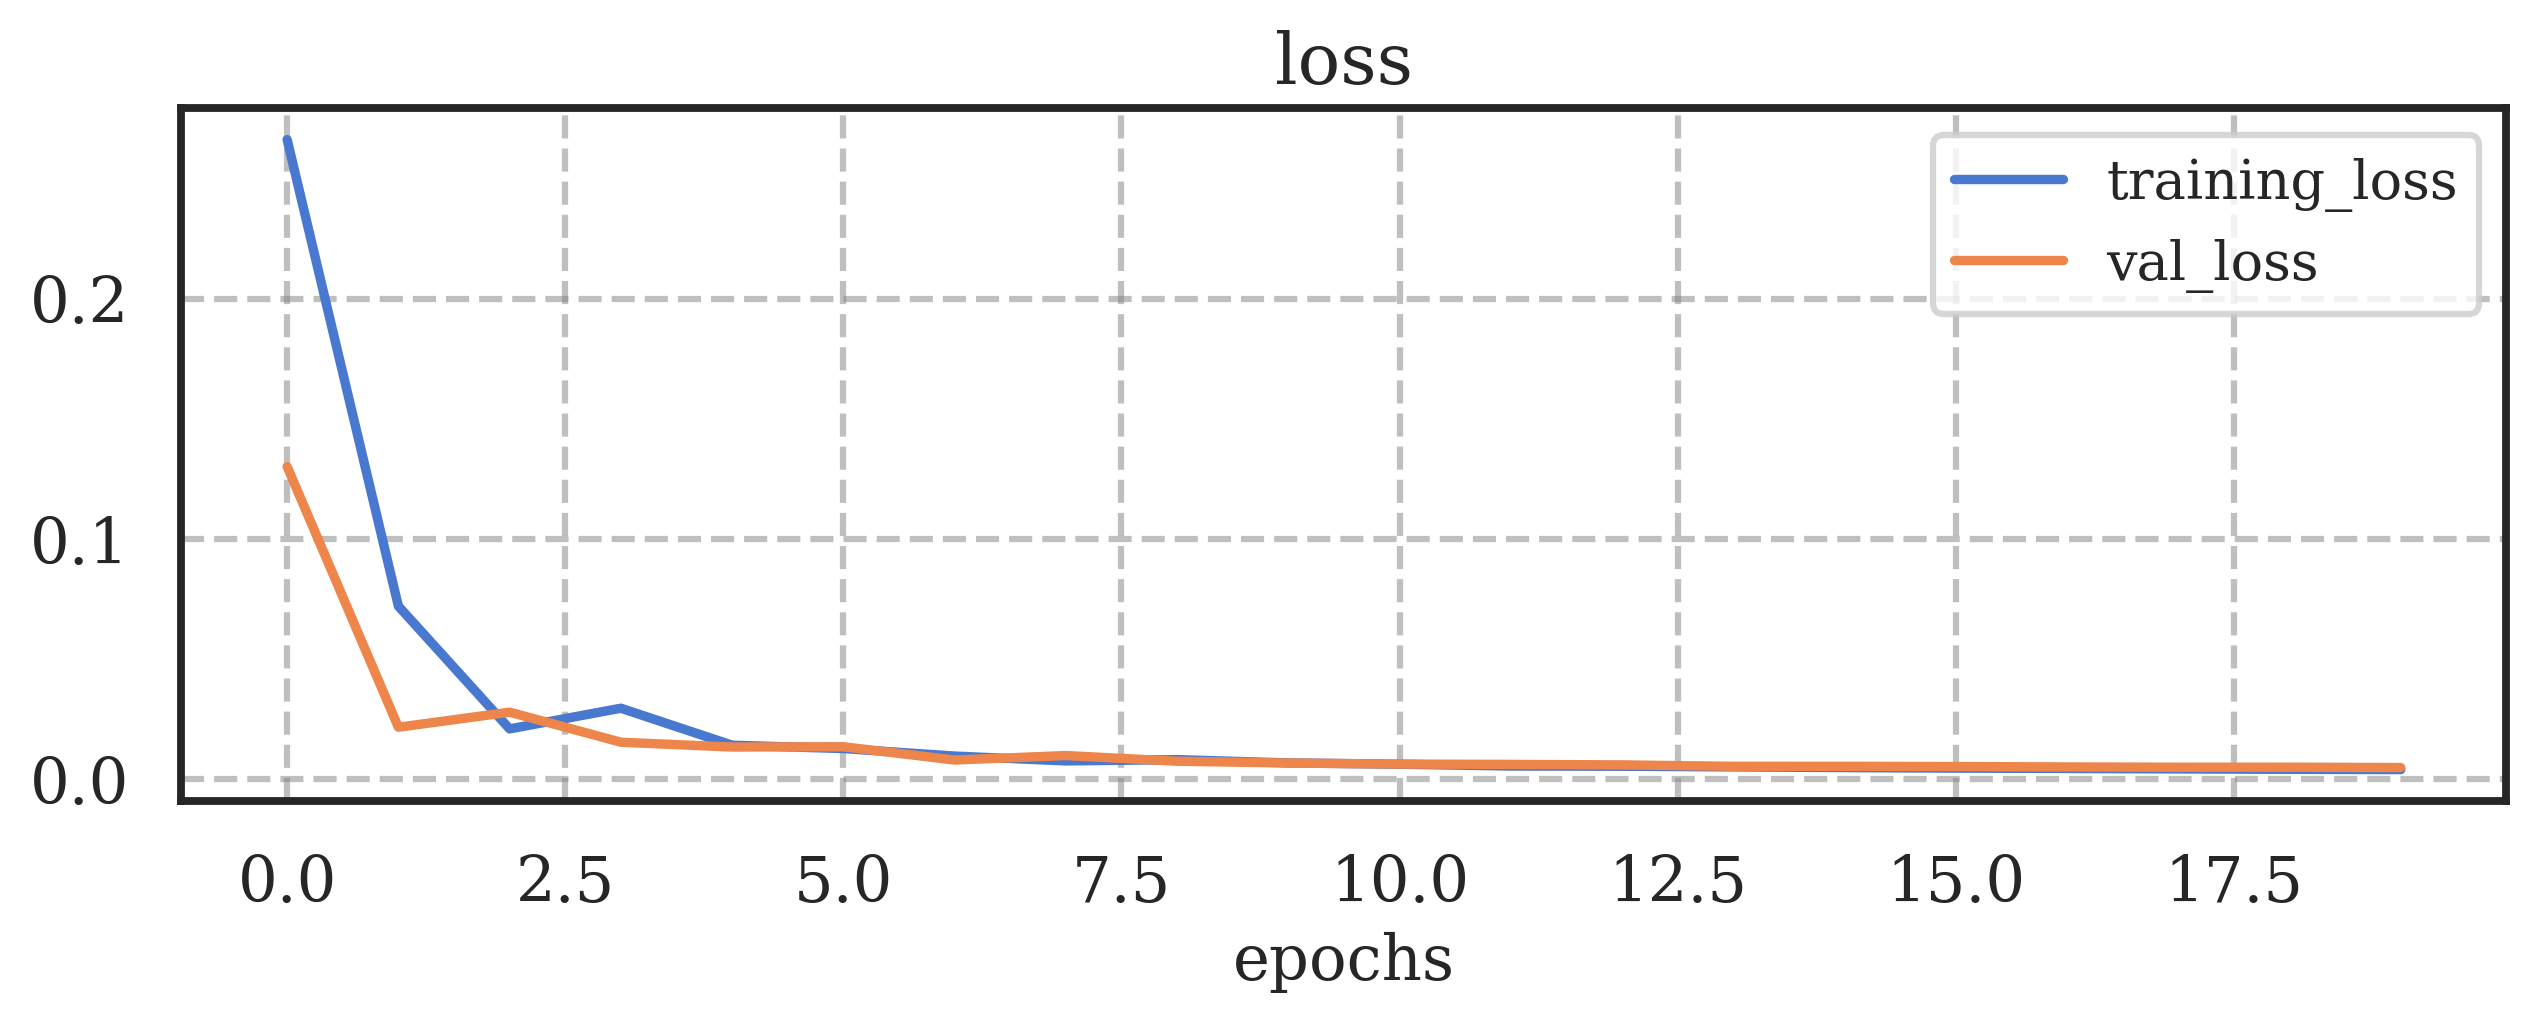

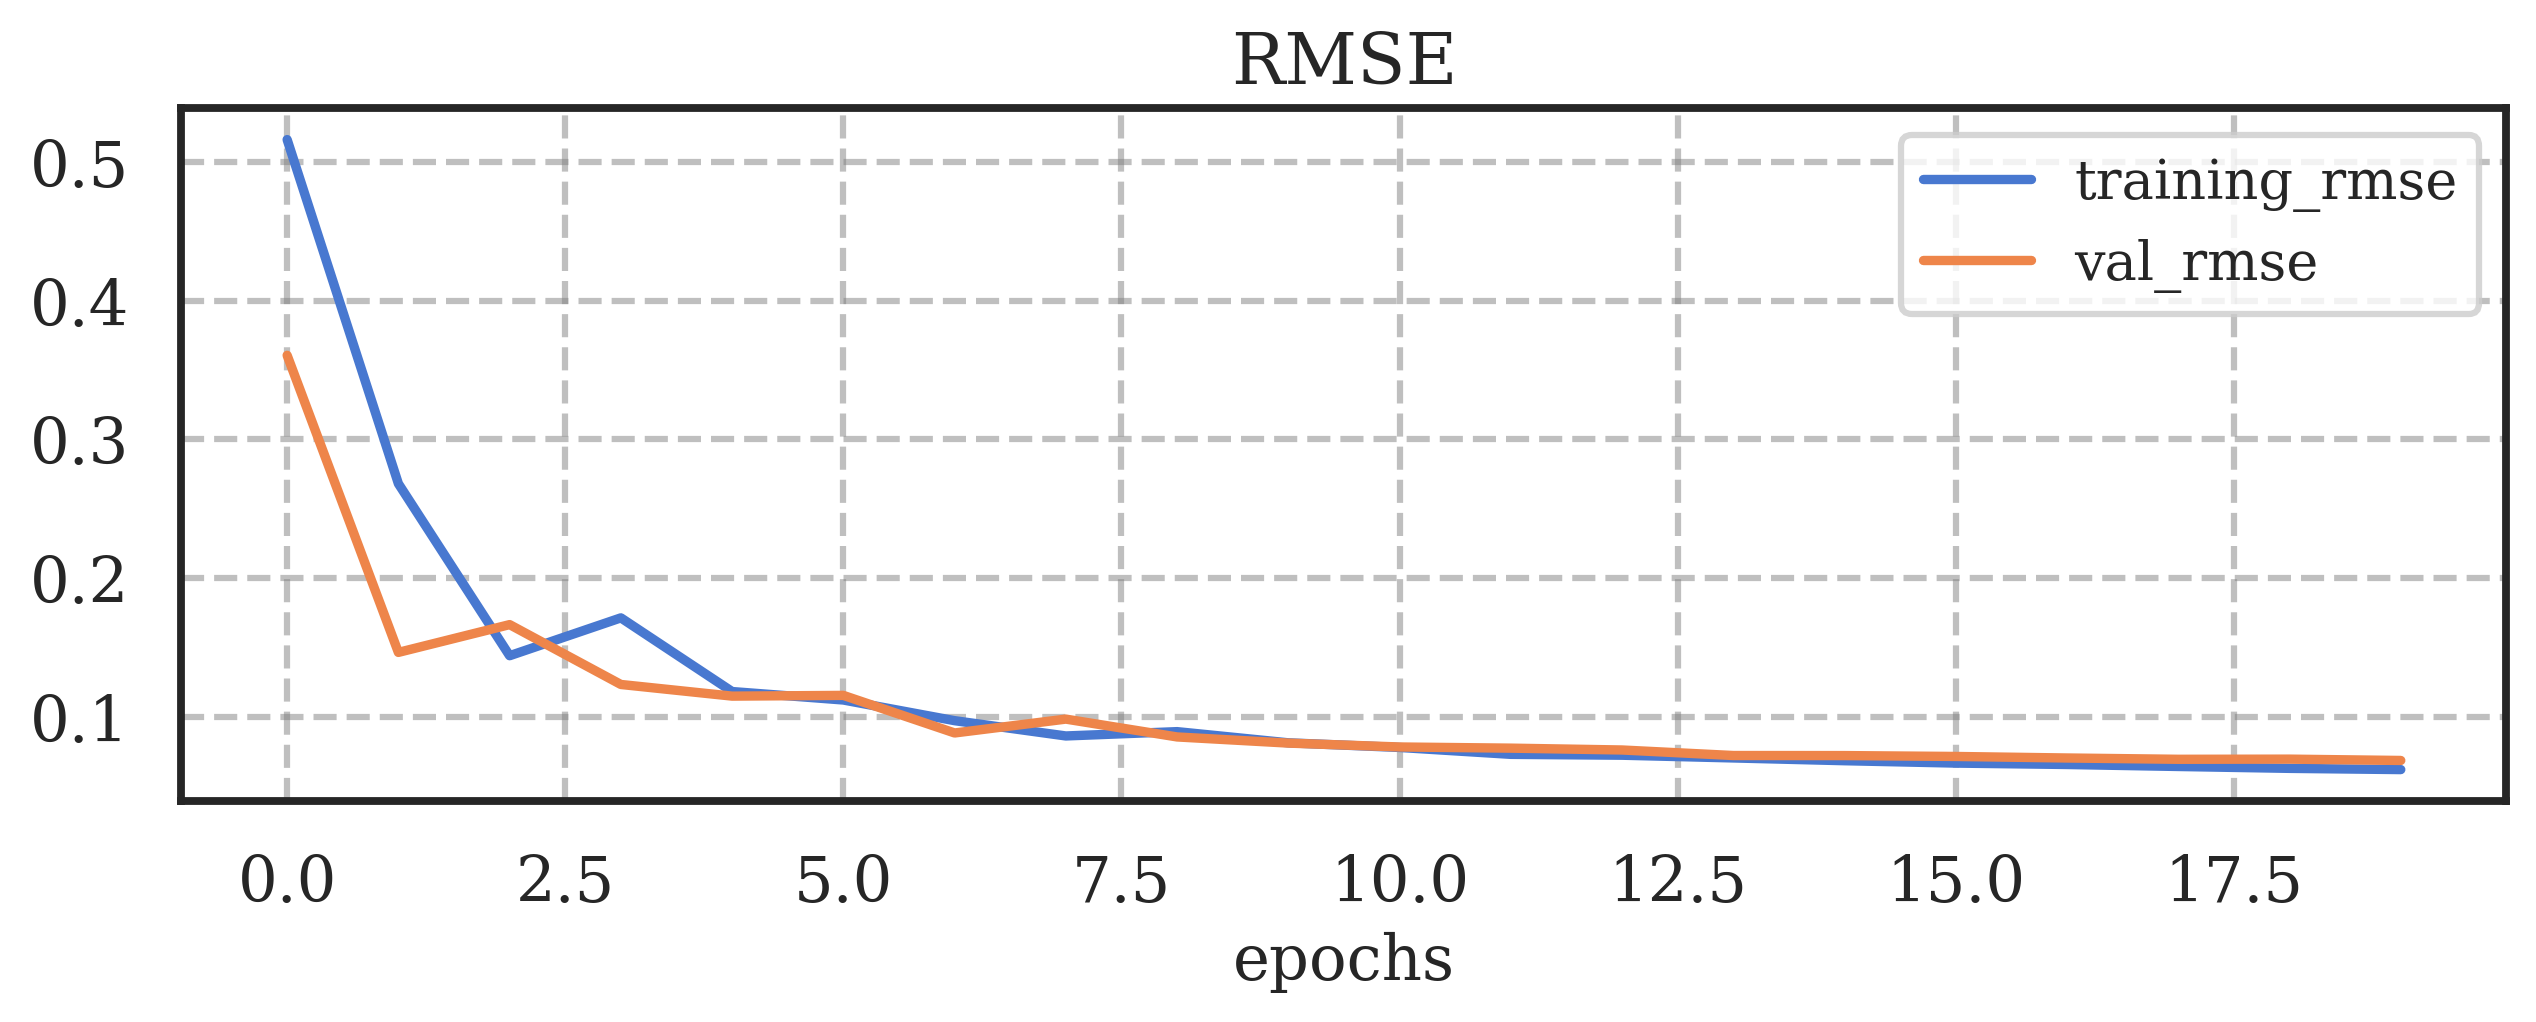

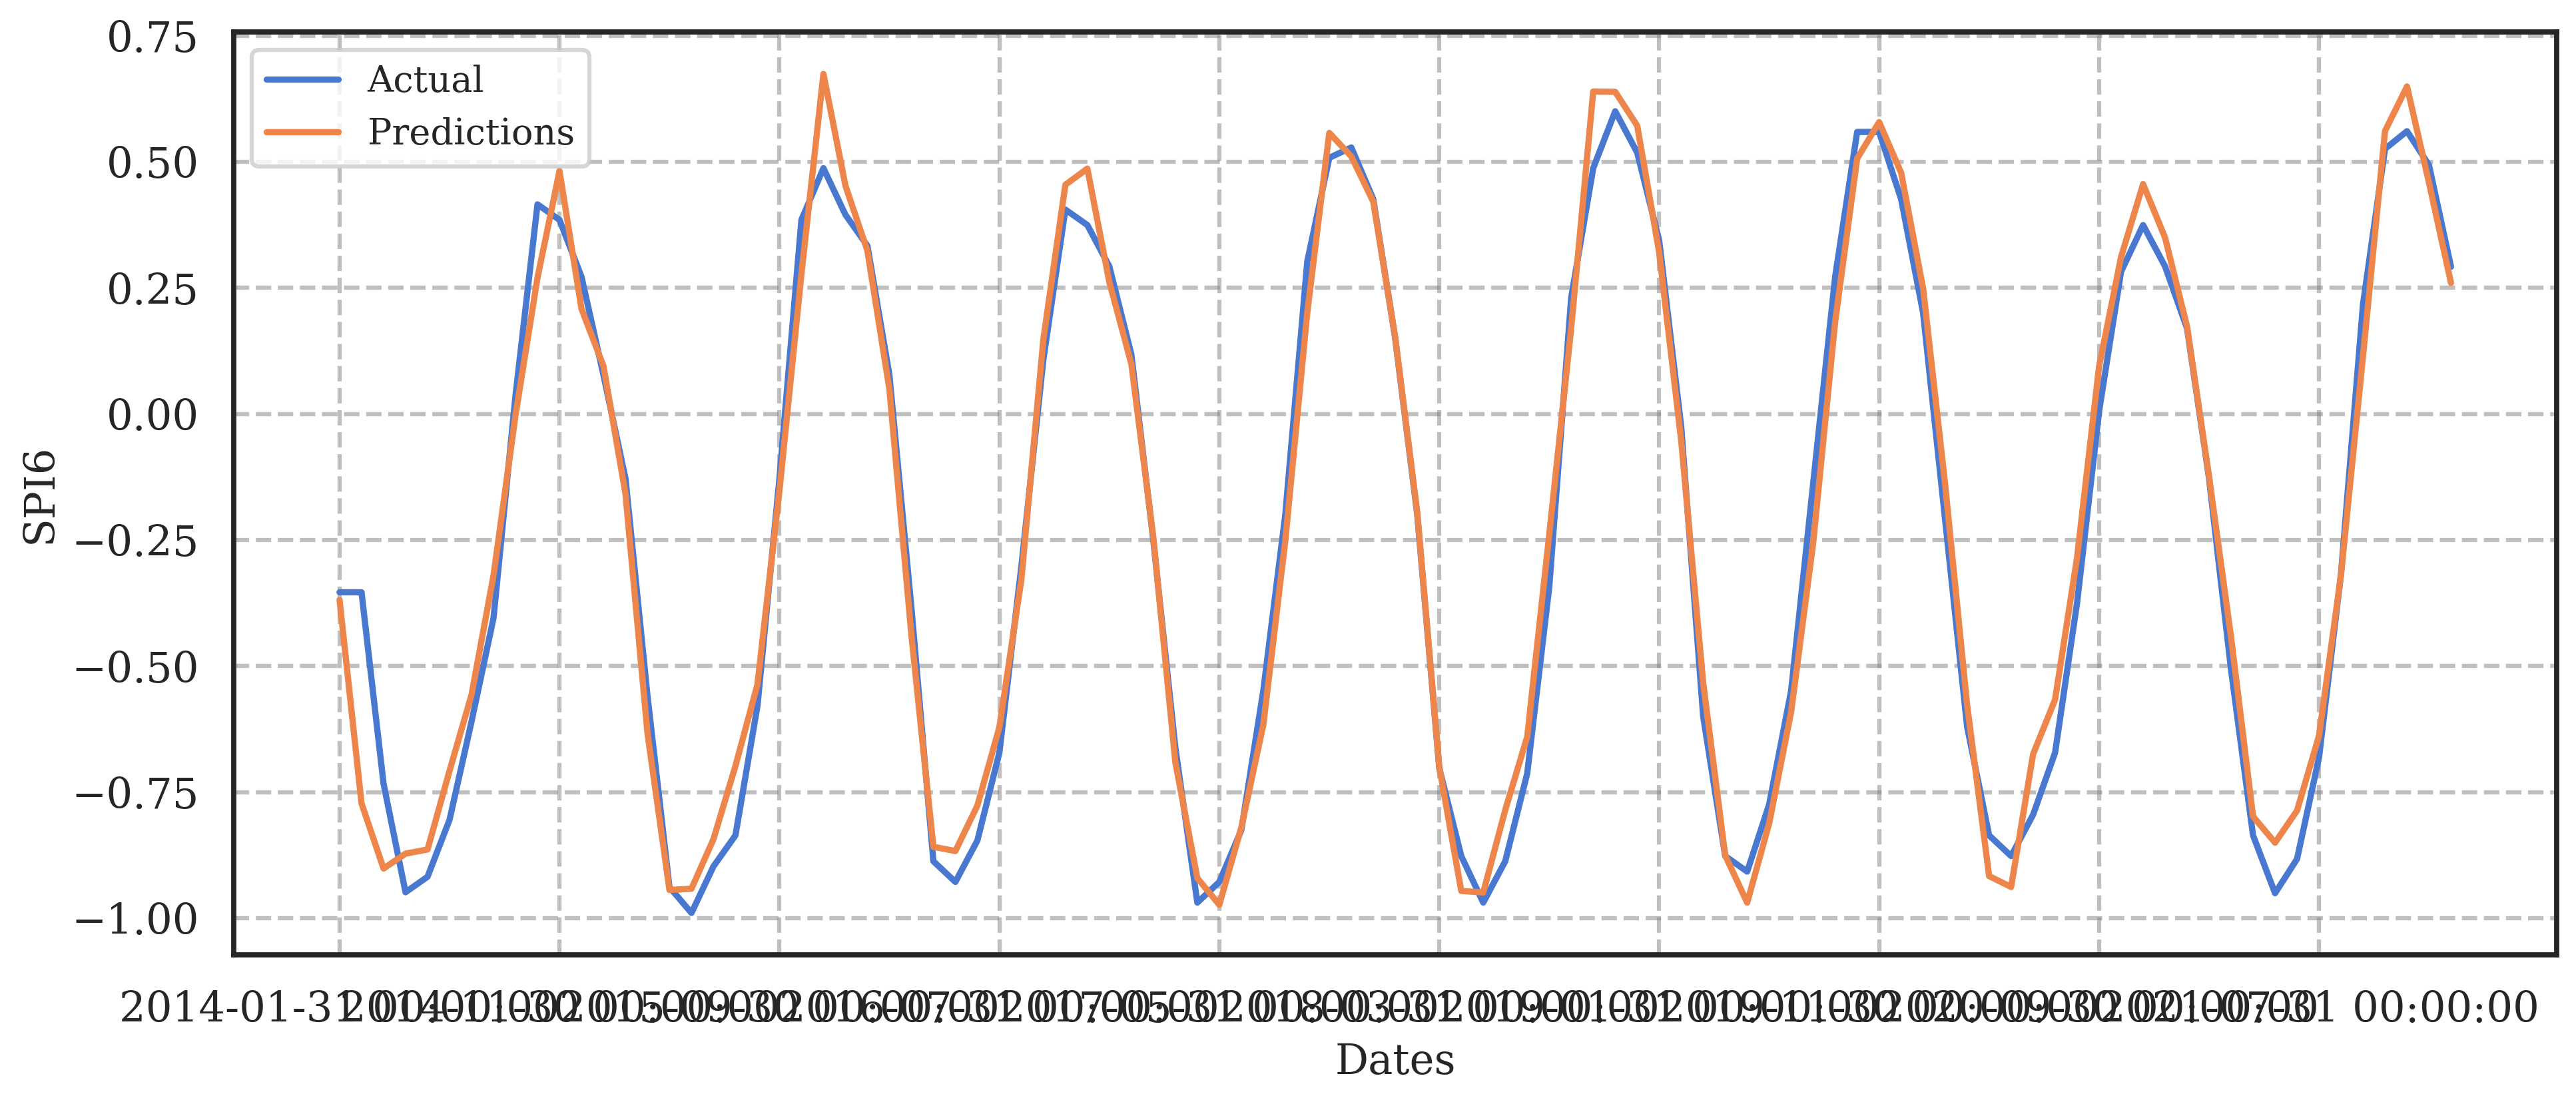

In [13]:
optimizer = Adam(learning_rate=conv1d_model_params['lr'])

CNN.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[RootMeanSquaredError()]
)


history = CNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=conv1d_model_params['epochs'],
    batch_size=conv1d_model_params['batch_size'],
    # callbacks=[early_stop],
    verbose=1
)

plot_loss_curves(history)

plt.savefig(save_path + dirs[0] + 'cnn_model_loss_acc')

y_pred = CNN.predict(X_test)


dl_plot_results_test(y_test, y_pred, dat=list(dataset_test.index))

plt.savefig(save_path + dirs[0] + 'cnn_model_actual_predict')

loss, rmse = CNN.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test RMSE: {rmse:.4f}")

conv1D_results = evaluate_preds_simple(y_test, y_pred)

print(conv1D_results)